# Final Project

The project aims to develop and implement a concept as a Jupyter notebook framework for the spatio-temporal harmonisation of ERA5 reanalysis data, enabling comparison with DWD station measurements.

## Project Parts

- Conceptual: definition of data processing workflow including
    - target temporal resolution and aggregation strategy
    - definition of matched records as basic unit to enable comparison
    - spatial and temporal harmonisation between gridded ERA5 data and point-based DWD observations
    - criteria for joining the two data sources (scheme for a joined table)
- Coding: implementation of defined concept in a suitable data processing workflow 
    - collecting ERA5 reanalysis data and DWD station observations
    - preparation and harmonisation of both data according to a matched-record concept
    - generation of a combined dataset suitable for comparison and basic evaluation
    - implement basic evaluation via metrics like bias and RMSE


## Imports and Prerequisites

In [1]:
import zipfile, requests
from datetime import date, datetime, timedelta
import io
import pandas as pd
from io import StringIO

import geopandas as gpd
import matplotlib.pyplot as plt

### Joined Table

In [2]:
JOINT_COLUMNS = [
    "station_id",
    "date",
    "avg_obs",
    "avg_era5",
    "n_obs ",
    "coverage",
    "lat",
    "lon",
    "station_heigh_m",
    "era5_lat",
    "era5_lon",
]

joint_df = pd.DataFrame(columns=JOINT_COLUMNS)
joint_df.head()


,station_id,date,avg_obs,avg_era5,n_obs,coverage,lat,lon,station_heigh_m,era5_lat,era5_lon


### DWD Station Data Pre-Processing (Aggregation) 

In [3]:
def aggregate_dwd():
    return
    

## Access data from the DWD

In [4]:
# dictionary that stores metadata on different DWD variables

DWD_PRODUCTS = {
    "air_temperature": {
        "code": "TU",
        "column_name": "TT_TU"
    },
    "wind": {
        "code": "FF",
        "column_name": "F"
    },
    "precipitation": {
        "code": "RR",
        "column_name": "R1"
    },
}

BASE_CDC = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly"

In [5]:
# Generates suitable CDC URL based on given paramters 

def dwd_zip_url(variable, station_id, mode="recent"):
    if variable not in DWD_PRODUCTS:
        raise KeyError(f"Unknown variable: {variable}")

    code   = DWD_PRODUCTS[variable]["code"]
    
    if mode == "recent":
        suffix = "akt"
    else:
        suffix = "hist"

    return f"{BASE_CDC}/{variable}/{mode}/stundenwerte_{code}_{station_id}_{suffix}.zip"


In [30]:
# Downloads data from DWD CDC in RAM and stores only the wanted data in a dataframe

def download_DWD_data(variable, station_id, date=None, start_date=None, end_date=None):

    zip_url = dwd_zip_url(variable, station_id, mode="recent")

    r = requests.get(zip_url, timeout=60)
    r.raise_for_status()

    zf = zipfile.ZipFile(io.BytesIO(r.content))
    produkt = next(
        n for n in zf.namelist()
        if n.lower().startswith("produkt_") and n.lower().endswith(".txt")
    )

    with zf.open(produkt) as f:
        df = pd.read_csv(f, sep=";")

    df.columns = (
        df.columns
          .astype(str)
          .str.strip()
          .str.replace(r"\s+", "", regex=True)
    )

    df["time"] = pd.to_datetime(df["MESS_DATUM"], format="%Y%m%d%H", errors="coerce")
    value_col = DWD_PRODUCTS[variable]["column_name"]

    if date is not None:
        target_date = pd.to_datetime(date).date()
        mask = df["time"].dt.date == target_date
    else:
        start = pd.to_datetime(start_date)
        end = pd.to_datetime(end_date) + pd.Timedelta(days=1)
        mask = (df["time"] >= start) & (df["time"] < end)

    df_out = df.loc[mask, ["time", value_col]].copy()
    df_out = df_out.rename(columns={value_col: variable}).sort_values("time")

    return df_out

### Selection of Stations

In [7]:
# find stations in NRW

state = "Nordrhein-Westfalen"
start_date = "2026-01-01"
end_date = "2026-01-24"
STATION_LIST_URL = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/recent/TU_Stundenwerte_Beschreibung_Stationen.txt"

r = requests.get(STATION_LIST_URL, timeout=60)
r.raise_for_status()
lines = r.content.decode("latin-1").splitlines()

# Keep only data lines (start with a digit)
data_lines = [ln for ln in lines if ln.strip() and ln.lstrip()[0].isdigit()]

rows = []
for ln in data_lines:
    parts = ln.split(None, 6)  # station_id, von_datum, bis_datum, Stationshoehe, geoBreite, geoLaenge, rest
    if len(parts) < 7:
        continue

    station_id, von, bis, height, lat, lon, rest = parts

    # Split 'rest' from the right into: Stationsname, Bundesland, Abgabe
    rest_parts = rest.rsplit(None, 2)
    if len(rest_parts) != 3:
        continue

    name, bundesland, status = rest_parts

    rows.append((
        station_id,
        int(von),
        int(bis),
        float(height),
        float(lat),
        float(lon),
        name,
        bundesland,
        status
    ))

stations = pd.DataFrame(
    rows,
    columns=["STATIONS_ID", "start_date", "end_date", "station_height_m", "lat", "lon", "stations_name", "State", "Abgabe"]
)

stations["STATIONS_ID"] = stations["STATIONS_ID"].astype(str).str.zfill(5)

start_int = int(pd.to_datetime(start_date).strftime("%Y%m%d"))
end_int   = int(pd.to_datetime(end_date).strftime("%Y%m%d"))

stations_nrw = stations[
    (stations["State"].str.strip() == state) &
    (stations["start_date"] <= start_int) &
    (stations["end_date"] >= end_int)
].copy()

stations_nrw = stations_nrw.sort_values("STATIONS_ID").reset_index(drop=True)

print("All stations parsed:", len(stations))
print("NRW stations covering full period:", len(stations_nrw))

stations_nrw.head(20)

All stations parsed: 658
NRW stations covering full period: 42


,STATIONS_ID,start_date,end_date,station_height_m,lat,lon,stations_name,State,Abgabe
0,00390,20040701,20260126,611.0,50.9837,8.3683,"Berleburg, Bad-Stünzel",Nordrhein-Westfalen,Frei
1,00555,20080101,20260126,110.0,51.5026,7.2289,Bochum,Nordrhein-Westfalen,Frei
2,00603,20010403,20260126,147.0,50.7293,7.2040,Königswinter-Heiderhof,Nordrhein-Westfalen,Frei
3,00617,20040601,20260126,47.0,51.8730,6.8863,Borken in Westfalen,Nordrhein-Westfalen,Frei
4,01078,19760301,20260126,37.0,51.2960,6.7686,Düsseldorf,Nordrhein-Westfalen,Frei
5,01246,20150801,20260126,104.0,51.8418,8.0607,Ennigerloh-Ostenfelde,Nordrhein-Westfalen,Frei
6,01300,20040601,20260126,351.0,51.2540,8.1565,Eslohe,Nordrhein-Westfalen,Frei
7,01303,19510101,20260126,150.0,51.4041,6.9677,Essen-Bredeney,Nordrhein-Westfalen,Frei
8,01327,20040801,20260126,147.0,50.7119,6.7905,Weilerswist-Lommersum,Nordrhein-Westfalen,Frei
9,01572,20020101,20260126,80.0,50.9593,6.0392,Geilenkirchen-Neutevern,Nordrhein-Westfalen,Frei


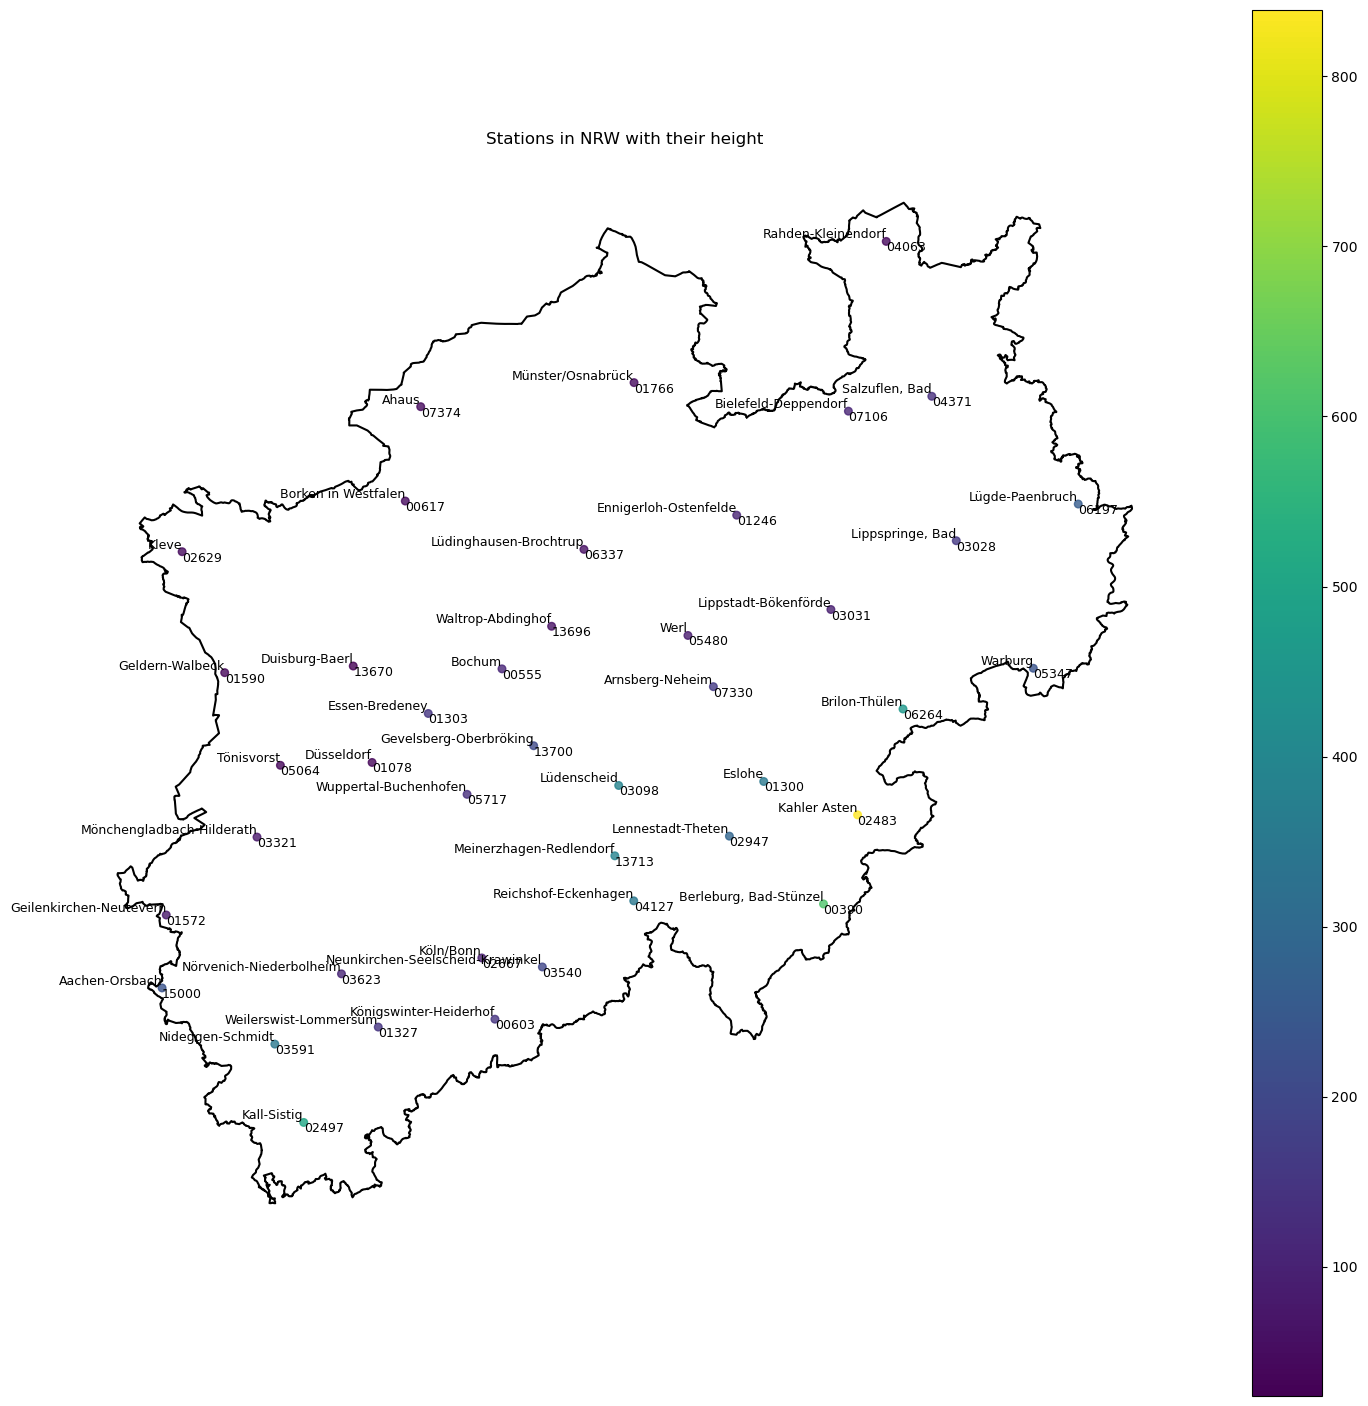

In [14]:
stations_gdf = gpd.GeoDataFrame(
    stations_nrw,
    geometry=gpd.points_from_xy(stations_nrw.lon, stations_nrw.lat),
    crs="EPSG:4326"
)

# Load NRW borders from GADM v4.1
gadm_zip = "https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_DEU_shp.zip"
de_states = gpd.read_file(f"zip+{gadm_zip}!gadm41_DEU_1.shp")
nrw = de_states[de_states["NAME_1"] == "Nordrhein-Westfalen"]

nrw = nrw.to_crs(stations_gdf.crs)

fig, ax = plt.subplots(figsize=(18, 18))

# plot NRW borders
nrw.boundary.plot(
    ax=ax,
    linewidth=1.5,
    color="black",
    aspect="equal"
)

# plot stations and color them regarding their height
stations_gdf.plot(
    ax=ax,
    column="station_height_m",        # 👈 Höhen-Spalte
    cmap="viridis",         # Farbskala
    markersize=30,
    legend=True,            # Farblegende
    alpha=0.8
)

for _, row in stations_gdf.iterrows():
    ax.text(
        row.geometry.x,
        row.geometry.y,
        str(row["STATIONS_ID"]),
        fontsize=9,
        ha="left",
        va="top"
    )

for _, row in stations_gdf.iterrows():
    ax.text(
        row.geometry.x,
        row.geometry.y,
        str(row["stations_name"]),
        fontsize=9,
        ha="right",
        va="bottom"
    )

ax.set_title("Stations in NRW with their height")
ax.set_axis_off()
plt.show()

Missingness rate by hour (0..23):
hour
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
Name: air_temperature, dtype: float64


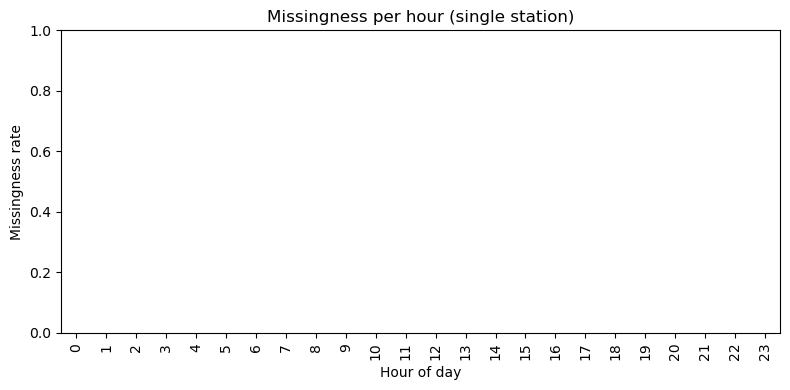

In [35]:
df = download_DWD_data(
    variable = "air_temperature",
    station_id = "02667",
    start_date="2026-01-01",
    end_date="2026-01-20",   
)

df["time"] = pd.to_datetime(df["time"])
df["hour"] = df["time"].dt.hour

missing_by_hour = (
    df.groupby("hour")["air_temperature"]
      .apply(lambda s: s.isna().mean())
      .reindex(range(24), fill_value=0.0)   # ensure 0..23 present
)

print("Missingness rate by hour (0..23):")
print(missing_by_hour)

availability_by_hour = (
    df.groupby("hour")["air_temperature"]
      .apply(lambda s: s.notna().mean())
      .reindex(range(24), fill_value=0.0)
)

print("Availability rate by hour (0..23):")
print(availability_by_hour)

plt.figure(figsize=(8, 4))
missing_by_hour.plot(kind="bar")
plt.xlabel("Hour of day")
plt.ylabel("Missingness rate")
plt.title("Missingness per hour (single station)")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## Testing

In [31]:
download_DWD_data(
    variable = "air_temperature",
    station_id = "02667",
    start_date="2026-01-10",
    end_date="2026-01-20",   
).head(48)

,time,air_temperature
12792,2026-01-10 00:00:00,0.9
12793,2026-01-10 01:00:00,0.6
12794,2026-01-10 02:00:00,0.4
12795,2026-01-10 03:00:00,0.2
12796,2026-01-10 04:00:00,0.0
12797,2026-01-10 05:00:00,-0.2
12798,2026-01-10 06:00:00,-0.2
12799,2026-01-10 07:00:00,0.0
12800,2026-01-10 08:00:00,-0.7
12801,2026-01-10 09:00:00,-0.8
